# TASK: Temperature and forecast deviations


In this task, we are provided a time series representing the physical deficit or surplus of electricity consumption in France during the year **2017**. This data exhibits the uncertainty in the prediction of electricity production and consumption by actors in the french electricity market. Since such deviations from actual consumption entail costs for market actors, it is important to aim at minimizing them, using whichever data available.

Temperature forecasts can be used as a basic indicator for deviations of energy consumption. Indeed, since usage of heating or air-conditioning is influenced by air temperature, utilities partly base their consumption forecast for a time period on a temperature forecast, especially during winter and summer. Thus, actual electricity consumption may be higher than anticipated if a summer is hotter or a winter is colder than expected and, conversely, consumption may be lower than anticipated if a summer is colder or a winter is warmer than expected.

I have decide to present my approach to the task in this Jupyter Notebook. It is a document containing text, visualizations and live code, which can be run interactively. To execute a code cell, select it and press shift + return. The square brackets at the left will contain a * while it runs, and a number when running ends. The output will appear right below the snippet.

Below are the libraries we will use.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(5,5)})
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_curve, auc


## Electricity consumption data

Since we will use the library `pandas`, our approach will rely on it's main data structure, called a *dataframe*. A dataframe can be understood as a table with a lot of flexibility for complicated data. In the text we will use the terms 'table' and 'dataframe' interchangeably. We start by loading the time series of consumption deviation in France (as a dataframe). 

In [2]:
dev_2017_pre = pd.read_csv('consumption_deviation_FR_new.csv', sep=';', decimal=',', parse_dates=['timestamp'])

The time seriers contains deviation records for every half-hour in the year 2017 (with the exception of December 31st, where the granularity is quarter-hourly)

In [3]:
dev_2017_pre

,timestamp,quantity
0,2017-01-01 00:00:00,"-44,875"
1,2017-01-01 00:30:00,"-18,125"
2,2017-01-01 01:00:00,"-10,375"
3,2017-01-01 01:30:00,"7,125"
4,2017-01-01 02:00:00,"-43,375"
...,...,...
17535,2017-12-31 22:45:00,"-21,48982889"
17536,2017-12-31 23:00:00,"-7,807809406"
17537,2017-12-31 23:15:00,"-56,69726053"
17538,2017-12-31 23:30:00,"21,83256871"


### Parsing data

Since pandas is not parsing the column 'quantity' as a number (a float), there must be values that don't correspond to numbers. To locate them, we instruct pandas first to replace the european comma decimal separator by a period, and to parse as `NaN` (Not a Number) everything it doesn't recognize as a number. 

In [4]:
print(dev_2017_pre.dtypes)

# coerce sets unparsed values as NaN

dev_2017_pre['quantity'] = pd.to_numeric(dev_2017_pre['quantity'].str.replace(',','.'), errors='coerce')

timestamp    datetime64[ns]
quantity             object
dtype: object


There are just three consecutive missing quantity values. Since deviation data seems rather random, there is no sensible way to fill them. Hence we will these entries unspecified for the moment.

In [5]:
dev_2017_pre[dev_2017_pre['quantity'].isnull()]

,timestamp,quantity
13594,2017-11-10 16:00:00,NaN
13595,2017-11-10 16:30:00,NaN
13596,2017-11-10 17:00:00,NaN


### Removing outliers

Recall that the mean of a list of values represents their average, while the median (denoted `50%` in the table below) denotes the value below which exactly half of the measurements lie. Since the mean and the median differ a lot, we suspect that the time series contains some extreme outliers which we need to take care of. Indeed, the minimum value, listed below, has such a large magnitude that it may well correspond to an error.

In [6]:
dev_2017_pre.describe()

,quantity
count,1.753700e+04
mean,-7.852510e+03
std,7.435333e+05
min,-7.898546e+07
25%,-3.087500e+01
50%,2.875000e+00
75%,3.875000e+01
max,5.651250e+02


This is evident in a plot of the time series. To produce the plot, we first need to set the timestamp as the index of the dataframe.

<AxesSubplot:xlabel='timestamp'>

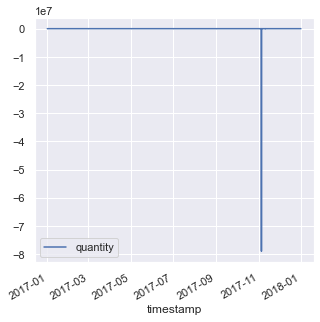

In [7]:
dev_2017_pre.set_index('timestamp', inplace=True, drop=True)
dev_2017_pre.plot()

Since the outliers seem indeed very scarce and have such a large magnitude, it is appropriate to remove them, lest they impair our statistical analysis. A reasonable way to do this is using *z-scores*. The z-score of a data point measures how far it lies from the mean value, as measured relative to the standard deviation (i.e. dispersion of the data). Here we retain data points that lie within three standard deviations of the mean. This will also remove the three consecutive `NaN` values noted above.

<AxesSubplot:xlabel='timestamp'>

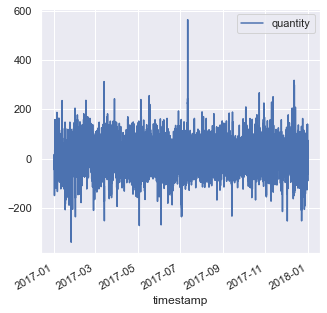

In [8]:
dev_2017 = dev_2017_pre.loc[(np.abs(stats.zscore(dev_2017_pre, nan_policy='omit'))<3)]
dev_2017.plot()

The new mean and minimum values in the dataframe confirm that the outliers we removed were indeed very anomalous.

In [9]:
dev_2017.describe()

,quantity
count,17535.000000
mean,4.126121
std,58.231903
min,-340.750000
25%,-30.875000
50%,2.875000
75%,38.750000
max,565.125000


### Setting data resolution

The task requires to compare consumption and temperature deviations on a daily basis. This is reasonable, since a finer resolution of half-hourly records of consumption deviation has a large variability.

The next step is therefore to aggregate (i.e. group) data on a daily basis, computing the mean consumption deviation for each day.

In [10]:
dev_2017_daily = dev_2017.resample('D').mean()

Note that the dataframe obtained contains 365 rows, so it's complete. With the coarser resolution we have also addressed the issue of removed data (either for being `NaN` or for being outliers). Since so few data points were removed, we can still regard the resulting average temperatures as representative of the actual measurements.

In [11]:
dev_2017_daily

,quantity
timestamp,
2017-01-01,-25.520833
2017-01-02,98.132812
2017-01-03,-36.273438
2017-01-04,34.421875
2017-01-05,25.817708
...,...
2017-12-27,-80.122396
2017-12-28,-33.854167
2017-12-29,5.757812


## Temperature data

For temperature records, we have at our disposal measurements from weather stations at airports in France. There are several stations scattered across France. 

Rather than restricting to one station, which only reflects temperature in one geographical site that may at best correlate with the local energy consumption, we will consider measurements from six stations which are geographically scattered (as determined 'by eye') and lie close to some of the most populated cities in France. 

The larger sample ensures that:
1. A temperature record be obtained that better reflects the geographic variability of temperature, which can be large.
2. The temperature measurements be associated with heavy energy consuming cities, which contribute a larger fraction to the mean energy consumption deviation in France

The weather stations chosen are:

- LFBO Toulousse
- LFLY Lyon
- LFML Marseille
- LFPB Paris
- LFRS Nantes
- LFQQ Lille

I will load data starting from year 2006, as more recent data tends to be more complete, and decide below which starting year encompasses more complete data while providing a solid historical record.

In [12]:
# Using index_col=['timestamp', 'station'] I adopt a hierarchical index,
# which makes it easier to categorize measurements by station

temperature_all_pre = pd.read_csv('asos_six_cities.txt', 
                                  sep=',', header=0, 
                                  names=['station', 'timestamp', 'temperature'], 
                                  parse_dates=['timestamp'], 
                                  index_col=['timestamp', 'station'])

In [13]:
temperature_all_pre.head(20)

temperature
timestamp           station             
2006-01-01 00:00:00 LFML             7.0
                    LFRS             3.0
                    LFBO             6.0
                    LFQQ             2.0
2006-01-01 00:30:00 LFBO             6.0
                    LFML             8.0
                    LFRS             3.0
2006-01-01 01:00:00 LFBO             6.0
                    LFML             8.0
                    LFRS             3.0
2006-01-01 01:30:00 LFRS             6.0
                    LFBO             6.0
                    LFML             8.0
2006-01-01 02:00:00 LFBO             6.0
                    LFRS             6.0
                    LFML             8.0
2006-01-01 02:30:00 LFML             8.0
                    LFBO             6.0
                    LFRS             6.0
2006-01-01 03:00:00 LFML             8.0

### Parsing data
It would be desirable to rearrange the table above so as to include one column for each of the weather stations considered, each containing the corresponding temperature measurements (i.e., to *unstack* the dataframe). However, at the moment we can't do this, since the dataframe contains repeated indices (somehow pandas doesn't check for repetition when assigning an index while reading).

In [14]:
temperature_all_pre[temperature_all_pre.index.duplicated(keep=False)].head(50)

temperature
timestamp           station             
2006-03-26 22:00:00 LFPB            17.0
                    LFML            16.0
                    LFML            16.0
                    LFRS            13.0
                    LFQQ            14.0
                    LFQQ            14.0
                    LFBO            13.0
                    LFBO            13.0
                    LFRS            13.0
                    LFPB            17.0
2006-03-26 22:30:00 LFBO            13.0
                    LFBO            13.0
                    LFPB            17.0
                    LFPB            17.0
                    LFML            16.0
                    LFML            16.0
2006-05-30 22:00:00 LFML            14.0
                    LFQQ             6.0
                    LFML            14.0
                    LFQQ             6.0
2006-05-30 22:30:00 LFML            14.0
                    LFML            14.0
2006-05-30 23:30:00 LFML            13.0
                    LFML            13.0
2006-07-30 23:00:00 LFML            26.0
                    LFML            26.0
2006-07-30 23:30:00 LFML            26.0
                    LFML            26.0
2006-12-30 23:30:00 LFBO             7.0
                    LFBO             7.0
2007-03-25 22:00:00 LFML             6.0
                    LFRS             6.0
                    LFRS             6.0
                    LFLY             3.0
                    LFLY             3.0
                    LFPB             5.0
                    LFPB             5.0
                    LFBO             6.0
                    LFBO             6.0
                    LFML             6.0
2007-03-25 22:30:00 LFML             6.0
                    LFML             6.0
                    LFLY             3.0
                    LFBO             5.0
                    LFPB             4.0
                    LFBO             5.0
                    LFPB             4.0
                    LFLY             3.0
2007-05-30 22:30:00 LFPB            14.0
                    LFLY            14.0

Let's remove duplicate index entries

In [15]:
temperature_all_unique = temperature_all_pre[~temperature_all_pre.index.duplicated(keep='first')]

Now we unstack the dataframe and try to assess what is a good starting year for our historical records. Note below that the weather stations LFLY and LFPB miss several values already starting year 2006.

In [16]:
temperature_all_stations_pre = temperature_all_unique.unstack()

In [17]:
temperature_all_stations_pre.head(60)

temperature                           
station                    LFBO LFLY  LFML LFPB LFQQ  LFRS
timestamp                                                 
2006-01-01 00:00:00         6.0  NaN   7.0  NaN  2.0   3.0
2006-01-01 00:30:00         6.0  NaN   8.0  NaN  NaN   3.0
2006-01-01 01:00:00         6.0  NaN   8.0  NaN  NaN   3.0
2006-01-01 01:30:00         6.0  NaN   8.0  NaN  NaN   6.0
2006-01-01 02:00:00         6.0  NaN   8.0  NaN  NaN   6.0
2006-01-01 02:30:00         6.0  NaN   8.0  NaN  NaN   6.0
2006-01-01 03:00:00         NaN  NaN   8.0  NaN  2.0   6.0
2006-01-01 03:30:00         6.0  NaN   8.0  NaN  NaN   NaN
2006-01-01 03:54:00         6.0  NaN   NaN  NaN  NaN   NaN
2006-01-01 04:00:00         NaN  NaN   8.0  NaN  2.0   8.0
2006-01-01 04:30:00         6.0  NaN   7.0  NaN  2.0   NaN
2006-01-01 05:00:00         6.0  3.0   6.0  NaN  2.0   8.0
2006-01-01 05:30:00         6.0  NaN   6.0  4.0  2.0   NaN
2006-01-01 06:00:00         6.0  2.0   5.0  4.0  3.0   9.0
2006-01-01 06:30:00         5.0  NaN   5.0  4.0  3.0   NaN
2006-01-01 07:00:00         5.0  2.0   NaN  5.0  3.0   9.0
2006-01-01 07:04:00         NaN  NaN   5.0  NaN  NaN   NaN
2006-01-01 07:30:00         5.0  NaN   4.0  5.0  3.0   NaN
2006-01-01 08:00:00         5.0  2.0   4.0  5.0  3.0   9.0
2006-01-01 08:30:00         6.0  NaN   4.0  6.0  3.0   NaN
2006-01-01 08:54:00         NaN  2.0   NaN  NaN  NaN   NaN
2006-01-01 09:00:00         6.0  NaN   4.0  6.0  3.0   9.0
2006-01-01 09:30:00         7.0  NaN   5.0  6.0  3.0   NaN
2006-01-01 10:00:00         8.0  4.0   6.0  6.0  3.0   9.0
2006-01-01 10:30:00         7.0  NaN   6.0  7.0  3.0   NaN
2006-01-01 11:00:00         8.0  7.0   8.0  7.0  3.0  10.0
2006-01-01 11:30:00         9.0  NaN   8.0  NaN  3.0   NaN
2006-01-01 12:00:00         NaN  7.0   9.0  8.0  3.0  10.0
2006-01-01 12:05:00         9.0  NaN   NaN  NaN  NaN   NaN
2006-01-01 12:30:00         9.0  NaN  10.0  8.0  3.0   NaN
2006-01-01 13:00:00         9.0  6.0  10.0  8.0  3.0   NaN
2006-01-01 13:11:00         NaN  NaN   NaN  NaN  NaN  10.0
2006-01-01 13:30:00         8.0  NaN  11.0  8.0  3.0   NaN
2006-01-01 14:00:00         9.0  5.0  10.0  8.0  3.0  10.0
2006-01-01 14:10:00         NaN  5.0   NaN  NaN  NaN   NaN
2006-01-01 14:30:00         9.0  NaN  10.0  8.0  3.0   NaN
2006-01-01 15:00:00         8.0  5.0  10.0  8.0  3.0   9.0
2006-01-01 15:30:00         7.0  NaN   9.0  8.0  4.0   NaN
2006-01-01 16:00:00         7.0  5.0   8.0  8.0  4.0   9.0
2006-01-01 16:30:00         7.0  NaN   7.0  7.0  4.0   NaN
2006-01-01 17:00:00         6.0  NaN   7.0  7.0  4.0   8.0
2006-01-01 17:30:00         7.0  NaN   6.0  7.0  4.0   NaN
2006-01-01 18:00:00         6.0  NaN   6.0  NaN  3.0   8.0
2006-01-01 18:30:00         6.0  NaN   6.0  NaN  4.0   NaN
2006-01-01 19:00:00         7.0  NaN   6.0  NaN  4.0   8.0
2006-01-01 19:30:00         7.0  NaN   6.0  NaN  4.0   NaN
2006-01-01 20:00:00         7.0  NaN   6.0  NaN  4.0   7.0
2006-01-01 20:30:00         NaN  NaN   6.0  NaN  4.0   NaN
2006-01-01 20:35:00         7.0  NaN   NaN  NaN  NaN   NaN
2006-01-01 21:00:00         7.0  NaN   6.0  NaN  4.0   7.0
2006-01-01 21:30:00         7.0  NaN   6.0  NaN  4.0   NaN
2006-01-01 22:00:00         7.0  NaN   6.0  NaN  4.0   7.0
2006-01-01 22:30:00         7.0  NaN   6.0  NaN  NaN   NaN
2006-01-01 23:00:00         6.0  NaN   6.0  NaN  4.0   7.0
2006-01-01 23:30:00         6.0  NaN   6.0  NaN  NaN   NaN
2006-01-02 00:00:00         6.0  NaN   6.0  NaN  4.0   6.0
2006-01-02 00:30:00         6.0  NaN   5.0  NaN  NaN   6.0
2006-01-02 01:00:00         7.0  NaN   4.0  NaN  NaN   6.0
2006-01-02 01:30:00         7.0  NaN   4.0  NaN  NaN   5.0
2006-01-02 02:00:00         7.0  NaN   4.0  NaN  NaN   5.0

The table below shows the percentage of missing values per year among the different weather stations. Note that starting from 2012, records may be qualified as sufficiently complete, but this would leave a short range of historical measurements.

In [18]:
df = temperature_all_stations_pre
missing_value_df = pd.DataFrame({str(y): df[str(y)].isnull().sum() * 100 / len(df[str(y)]) for y in range(2006,2018)})
display(missing_value_df)

2006       2007       2008       2009       2010  \
            station                                                          
temperature LFBO     11.235721   8.479268   8.099439   6.964932   7.808307   
            LFLY     77.961504  36.115399  31.082598  29.772519  29.634002   
            LFML     10.734964   8.484590   7.623630   6.770411   7.636578   
            LFPB     12.425017   8.638952   8.110131   6.581294   7.663411   
            LFQQ     23.165197  14.462128  13.803796  12.573621  13.040678   
            LFRS     44.603829  43.040400  41.422080  42.475820  41.773103   

                          2011      2012      2013      2014      2015  \
            station                                                      
temperature LFBO      6.518898  3.636060  2.844236  2.795447  2.734919   
            LFLY     22.116327  3.524695  2.721544  2.884723  2.634657   
            LFML      6.731293  4.643911  3.892700  3.995090  3.626135   
            LFPB      5.571289  3.719583  3.998662  2.695012  2.801760   
            LFQQ     11.698072  8.157470  7.768669  7.214597  3.330920   
            LFRS     30.040301  4.877777  3.898277  3.771900  3.453462   

                         2016      2017  
            station                      
temperature LFBO     3.271292  1.894785  
            LFLY     2.566272  0.955979  
            LFML     2.363226  1.230752  
            LFPB     3.846588  1.728777  
            LFQQ     3.102087  2.610338  
            LFRS     2.413988  1.425382

Since we don't require the finest half-hourly resolution, let's adopt 2007 as starting year, where the data from LFLY becomes substantially more complete

In [19]:
starting_year = '2007'
temperature_all_stations = temperature_all_stations_pre[starting_year:]

The mean and median lie close to each other, so there are likely no outliers that might affect our analysis.

In [20]:
temperature_all_stations.describe() 

temperature                                               \
station           LFBO           LFLY           LFML           LFPB   
count    189844.000000  169534.000000  189494.000000  189795.000000   
mean         14.048213      12.951225      15.814802      12.071477   
std           7.558399       8.151020       7.634371       7.069095   
min         -12.000000     -12.000000      -9.000000     -12.000000   
25%           9.000000       7.000000      10.000000       7.000000   
50%          14.000000      13.000000      16.000000      12.000000   
75%          19.000000      19.000000      22.000000      17.000000   
max          40.000000      39.000000      39.000000      39.000000   

                                       
station           LFQQ           LFRS  
count    182000.000000  159416.000000  
mean         11.182549      12.410385  
std           6.766268       6.378766  
min         -13.000000      -8.000000  
25%           6.000000       8.000000  
50%          11.000000      12.000000  
75%          16.000000      17.000000  
max          35.000000      37.000000

### Setting data resolution

Here we will again opt for a daily resolution of temperature data. First we compute daily averages for each station.

In [21]:
temperature_stations_daily = temperature_all_stations.resample('D').mean()

In [22]:
temperature_stations_daily

temperature                                                       
station           LFBO       LFLY       LFML       LFPB       LFQQ       LFRS
timestamp                                                                    
2007-01-01    9.428571  10.777778  12.941176   8.885714   7.387097   9.166667
2007-01-02    8.833333   6.416667   9.854167   7.166667   6.522727   8.481481
2007-01-03    7.595745   6.750000   8.062500   7.541667   6.782609   7.724138
2007-01-04    8.361702   5.400000   6.804348   9.687500   9.697674  11.000000
2007-01-05   10.270833   6.909091  10.562500  10.391304   9.386364  10.810811
...                ...        ...        ...        ...        ...        ...
2017-12-26    7.791667   9.750000  11.791667   6.770833   6.125000   7.458333
2017-12-27    6.333333   7.020833   9.104167   5.250000   5.145833   5.541667
2017-12-28    4.979167   2.666667   5.812500   2.583333   1.958333   3.208333
2017-12-29    7.729167   1.458333   4.312500   4.187500   3.229167  10.187500
2017-12-30   12.625000   7.312500   8.229167  12.895833  10.750000  13.208333

[4017 rows x 6 columns]

Note that the last record corresponds to December 30 2017, and not to December 31st. Let us make sure that the datetime index comprises all days in the period under consideration, by adding any days that may be missing. 

In [23]:
last_year = '2017'
complete_index = pd.date_range(start=starting_year+'-01-01', end=last_year+'-12-31', freq='D')
temperature_daily = temperature_stations_daily.reindex(complete_index)

Now we check if there are days besides December 30th for which no weather station reports temperature measurements.

In [24]:
temperature_daily[temperature_daily.isnull().any(axis=1)]

temperature                                                     
station           LFBO      LFLY       LFML      LFPB       LFQQ       LFRS
2008-03-28   10.520833       NaN  11.875000  6.276596   5.909091   9.659574
2012-07-15         NaN       NaN        NaN       NaN        NaN        NaN
2013-04-30   10.187500  12.37500  17.458333       NaN  10.000000   9.833333
2016-08-17   24.375000  24.06383  24.062500       NaN  20.354167  21.229167
2017-12-31         NaN       NaN        NaN       NaN        NaN        NaN

We fill each of those missing records with the last previous non-null value.  This is appropriate because not many values are missing, and don't expect huge day-to-day variations of temperature.

In [25]:
temperature_daily.fillna(method='ffill', inplace=True)

Let us finally add a column containing the row (station-wise) mean temperature and another the corresponding standard deviation.

In [26]:
temperature_daily.columns = temperature_daily.columns.get_level_values(1)

temperature_daily['mean'] = temperature_daily.mean(axis=1)
temperature_daily['std'] = temperature_daily.std(axis=1)

In [27]:
temperature_daily

station,LFBO,LFLY,LFML,LFPB,LFQQ,LFRS,mean,std
2007-01-01,9.428571,10.777778,12.941176,8.885714,7.387097,9.166667,9.764501,1.732655
2007-01-02,8.833333,6.416667,9.854167,7.166667,6.522727,8.481481,7.879174,1.268880
2007-01-03,7.595745,6.750000,8.062500,7.541667,6.782609,7.724138,7.409443,0.483993
2007-01-04,8.361702,5.400000,6.804348,9.687500,9.697674,11.000000,8.491871,1.897303
2007-01-05,10.270833,6.909091,10.562500,10.391304,9.386364,10.810811,9.721817,1.333307
...,...,...,...,...,...,...,...,...
2017-12-27,6.333333,7.020833,9.104167,5.250000,5.145833,5.541667,6.399306,1.374443
2017-12-28,4.979167,2.666667,5.812500,2.583333,1.958333,3.208333,3.534722,1.385934
2017-12-29,7.729167,1.458333,4.312500,4.187500,3.229167,10.187500,5.184028,2.914543
2017-12-30,12.625000,7.312500,8.229167,12.895833,10.750000,13.208333,10.836806,2.319821


### Preparing dataframes for analysis

The last step of data preparation consists of creating a dataframe of daily mean temperatures for 2017 and one of daily historical mean temperatures. We start with the 2017 dataframe.

In [28]:
temp_last_daily = temperature_daily.loc[last_year][['mean']]

To produce a dataframe with historical mean temperatures for each day of the year, we need to aggregate the rows by day, regardless of year

In [29]:
next_to_last=str(int(last_year)-1)
temp_hist_daily_pre = temperature_daily[:next_to_last][['mean']] 
temp_hist_daily_pre['time_of_year'] = temp_hist_daily_pre.index.strftime('%m-%d %H:%M:%S')

temp_hist_daily_leap = temp_hist_daily_pre.groupby('time_of_year').mean()

The resulting dataframe will contain one row corresponding to the leap day February 29th. Since 2017 is not leap, we remove it to obtain compatible dataframes

In [30]:
if temp_last_daily.index.is_leap_year.all(): 
    temp_hist_daily = temp_hist_daily_leap    
else: temp_hist_daily = temp_hist_daily_leap[~temp_hist_daily_leap.index.str.contains('02-29', regex=False)]

After being grouped by `time_of_year`, the dataframe is indexed by a string. Since we would like to interpret it as a real timestamp that should be compared with the data for year 2017, we make a datetime index out of it.

In [31]:
temp_hist_daily['not_a_timestamp'] = pd.to_datetime(last_year+'-'+temp_hist_daily.index)

<ipython-input-31-2bdf23d60f32>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_hist_daily['not_a_timestamp'] = pd.to_datetime(last_year+'-'+temp_hist_daily.index)


In [32]:
temp_hist_daily.set_index('not_a_timestamp', inplace=True, drop=True)

The obtained dataframe consists of reference historical mean values for every day of the year 2017.  Each value equals the average of the daily mean temperature on the given date over the historical record (from 2007 to 2016 in this case).

In [33]:
temp_hist_daily

station,mean
not_a_timestamp,
2017-01-01,6.173527
2017-01-02,5.669386
2017-01-03,5.660987
2017-01-04,5.923255
2017-01-05,5.737905
...,...
2017-12-27,5.430167
2017-12-28,5.242146
2017-12-29,5.570469


## Relating temperature deviations with consumption deviations

### Data preparation

Let's first gather the variables relevant for our analysis in a single dataframe. 

In [34]:
temperature_consumption = pd.concat([dev_2017_daily,
                                     temp_hist_daily,
                                     temp_last_daily], 
                                    axis=1,
                                    keys=['surplus',
                                          'temp_hist',
                                          'temp_'+str(last_year)])

# this is to make sure the column labels are those passed as keys in the concatenation
temperature_consumption.columns = temperature_consumption.columns.get_level_values(0)

temperature_consumption.index.name = 'timestamp'

We derive first the deviation of the mean daily temperature in 2017 from the historical mean temperature for the corresponding date.

In [35]:
temperature_consumption['temp_deviation'] = temperature_consumption['temp_2017']-temperature_consumption['temp_hist']

Since we are required to estimate the probability of deficit or surplus in the electrical grid, we add a corresponding *categorical value* to the dataframe. Its value is one if there is a surplus or a perfect balance, and zero if there is a deficit.

In [36]:
def surplus(x): return np.ceil((np.sign(x)+1)/2)

# .astype('category') would yield a categorical type
temperature_consumption['surplus_cat'] = temperature_consumption['surplus'].map(surplus).astype('int')


In [37]:
temperature_consumption

,surplus,temp_hist,temp_2017,temp_deviation,surplus_cat
timestamp,,,,,
2017-01-01,-25.520833,6.173527,0.950534,-5.222992,0
2017-01-02,98.132812,5.669386,3.193579,-2.475806,1
2017-01-03,-36.273438,5.660987,1.580530,-4.080457,0
2017-01-04,34.421875,5.923255,2.662430,-3.260825,1
2017-01-05,25.817708,5.737905,3.032828,-2.705077,1
...,...,...,...,...,...
2017-12-27,-80.122396,5.430167,6.399306,0.969139,0
2017-12-28,-33.854167,5.242146,3.534722,-1.707423,0
2017-12-29,5.757812,5.570469,5.184028,-0.386442,1


Since we expect the relation between temperature and consumption deviations to be conditioned by the seasonal temperature, it is reasonable to categorize dates according to meteorological season before doing the analysis (any existing relation might be averaged out otherwise). Meteorological seasons differ from the astronomical seasons in that they begin with the month and exhibit the hottest (in summer) and the coldest (in winter) quarters of the year.

In [38]:
def get_season(timestamp):
    
    spring = range(3,6)
    summer = range(6,9)
    autumn = range(9,12)
        
    if timestamp.month in spring: return 'Spring'
    elif timestamp.month in summer: return 'Summer'
    elif timestamp.month in autumn: return 'Autumn'
    else: return 'Winter'

temperature_consumption['season'] = temperature_consumption.index.map(get_season)

temperature_consumption_seasonal = {k: g for k, g in temperature_consumption.groupby('season')}

seasons = ['Winter', 'Spring', 'Summer', 'Autumn']

For the implementation of the statistical models we will consider, we require numerical arrays containing the variables of interest for the seasons summer and winter.

In [39]:
# .reshape(-1, 1) is required to have the X as a two-dimensional array, in this case
# a single column of data

X_winter = temperature_consumption_seasonal['Winter']['temp_deviation'].values.reshape(-1, 1)
y_winter = temperature_consumption_seasonal['Winter']['surplus_cat'].values
X_summer = temperature_consumption_seasonal['Summer']['temp_deviation'].values.reshape(-1, 1)
y_summer = temperature_consumption_seasonal['Summer']['surplus_cat'].values

### Exploratory data analysis

To get an idea of what we may expect from our data, let us inspect some of its statistical properties.

First, we consider a scatter plot of the data, that is, a plot of the pairs `(temp_deviation, surplus)` for all 365 days of the year, along with histograms of temperature deviation and surplus (recall that a histogram is a plot that divides the range of values in intevals, or bins, and assigns to each interval the number of values it comprises). At first sight, there is no clear statistical trend.

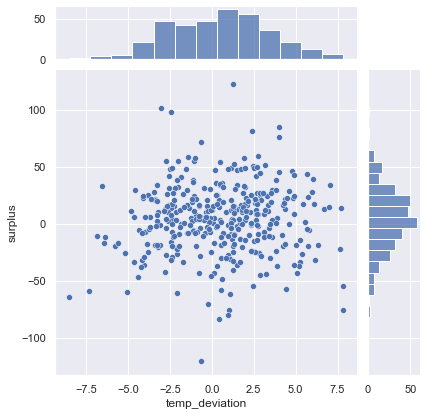

In [40]:
sns.jointplot(data=temperature_consumption, x='temp_deviation', y='surplus', marginal_ticks=True, joint_kws=dict(ci=None),
                  marginal_kws=dict(kde=False))

It seems thus reasonable to stratify the data by season to search for statistical trends. Let's have a look at the boxplots for temperature deviation and surplus for each season. The horizontal lines in each box represent the minimum, 25% quantile, 50% quantile (i.e. median), 75% quantile and the maximum, from top to bottom. Notice that while the surplus median seems to be centered about grid balance, the temperature deviation median shows different trends for different seasons.

<AxesSubplot:xlabel='season', ylabel='temp_deviation'>

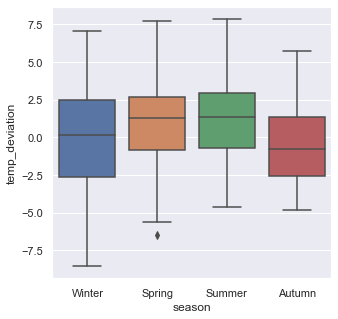

In [41]:
sns.boxplot(data=temperature_consumption, x='season', y='temp_deviation')

<AxesSubplot:xlabel='season', ylabel='surplus'>

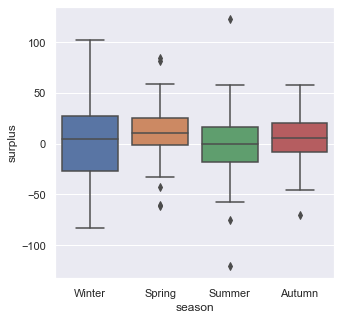

In [42]:
sns.boxplot(data=temperature_consumption, x='season', y='surplus')

To inspect whether we may expect the data to support a classification into surplus or deficit, let us decompose the histograms for temperature deviation and surplus, for both winter and summer, according to surplus or deficit (see *Advice* in the task statement). Notice that while there seems to be some separation between both classes of data, it is not very pronounced. This will limit the scope of our analysis. 

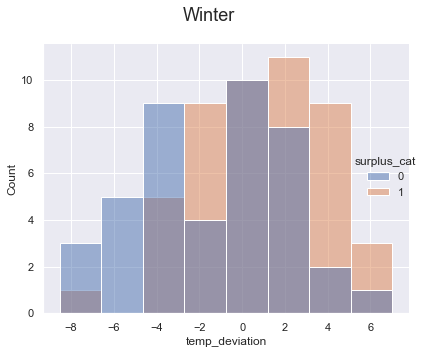

In [43]:
season = 'Winter'
p = sns.displot(temperature_consumption_seasonal[season], x='temp_deviation', hue='surplus_cat')
p.fig.suptitle(season, fontsize=18)
p.fig.tight_layout()

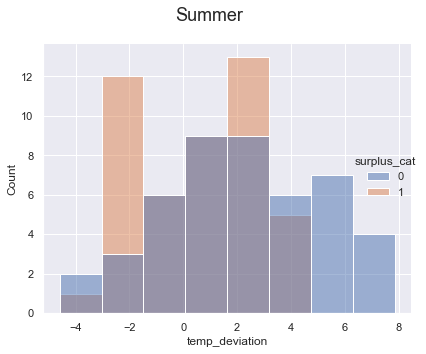

In [44]:
season = 'Summer'
p = sns.displot(temperature_consumption_seasonal[season], x='temp_deviation', hue='surplus_cat')
p.fig.suptitle(season, fontsize=18)
p.fig.tight_layout()

Now we take a look at seasonal scatter plots, that we enrich with histograms for the surplus and temperature deviation distributions, and a linear regression, to have an impression of the correlation between both variables.

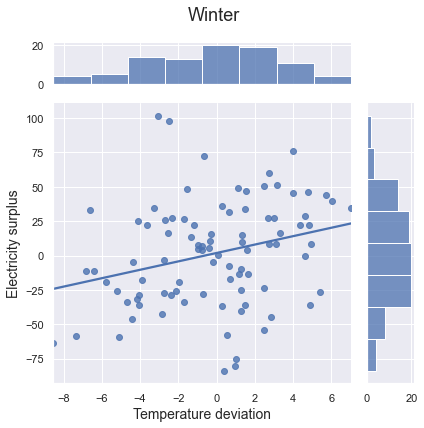

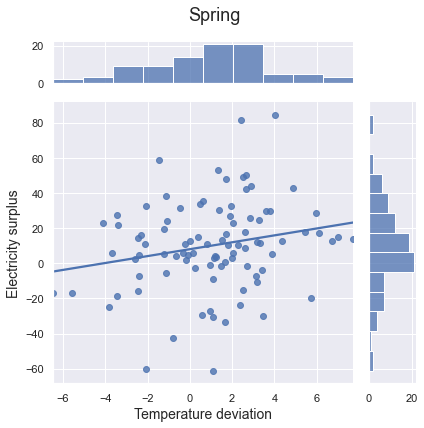

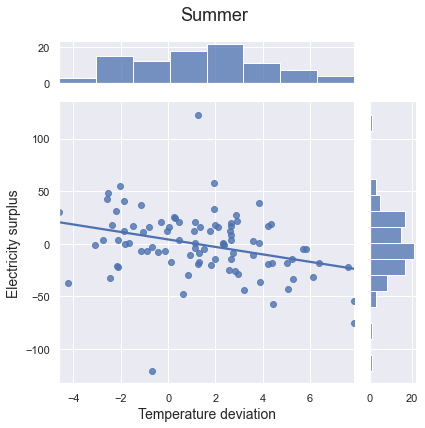

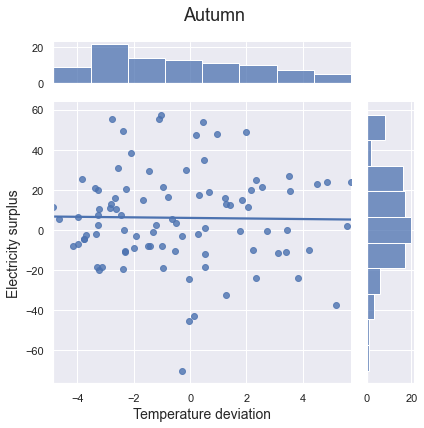

In [45]:
for season in seasons: 
    p = sns.jointplot(data=temperature_consumption_seasonal[season],
                  x='temp_deviation', y='surplus', kind='reg',
                  marginal_ticks=True, joint_kws=dict(ci=None),
                  marginal_kws=dict(kde=False))
    p.fig.suptitle(season, fontsize=18)
    p.fig.tight_layout()
    p.set_axis_labels('Temperature deviation', 'Electricity surplus', fontsize=14)






The (Pearson) correlation coefficient takes values in the interval [-1,1], and quantifies the extent to which a linear relation might possibly hold between temperature and consumption deviations. A magnitude of 1 corresponds to a perfect linear relation (all datapoints would lie on a line), while a magnitude of 0 corresponds to no linear relation. As suspected from the plots above, the values computed below confirm that a linear trend might hold at best for winter and for summer data.

In [46]:
pd.DataFrame({'Season': [season for season in seasons],'Pearson correlation': [temperature_consumption_seasonal[season]['temp_deviation'].corr(temperature_consumption_seasonal[season]['surplus']) for season in seasons]})

,Season,Pearson correlation
0,Winter,0.273497
1,Spring,0.213786
2,Summer,-0.316538
3,Autumn,-0.015630


### Question

Can we say with a certain probability that we will have a surplus or a deficit in the grid depending on the temperature deviation?

#### Answer:

The task presented belongs to the class of statistical problems known as *classification problems*. Here, we aim to relate the possible outcomes of a **finite** variable to other *predictor* variables that we suspect may bear an influence on it. In our situation, the finite variable is `surplus_cat`: whether electricity consumption in France exhibited (on average) a surplus or deficit on a given day. The predictor variable we are currently accounting for is `temp_deviation`: by how much did the actual daily mean temperature on a given day in 2017 differ from the historical mean daily temperature on that day in previous years.

Statistical models to address classification problems provide an estimate of the probability for the outcomes of the finite variables (e.g. `surplus_cat`) given the values of the predictor variables (e.g. `temp_deviation`), so in general terms, the answer to the above question is **yes**. In the present case, however, such probability estimate would be rather coarse, since the consumption deviation data covers only year 2017. If we had earlier records at our disposal, it would be possible to benchmark the quality of the probability estimate against its performance on the historical records. 

On the other hand, we are considering only the possible effect of temperature deviations on consumption deviations. Ideally, further variables besides temperature deviations should be available, which could capture the statistical nature of consumption deviations more faithfully and give us room (dimensions) to carry out a finer analysis.

With that said, given the limited data, it is appropriate to favor simple models over more complicated ones, which more strongly rely on a richer availability of data (such as machine learning models).

### Assessing performance:

Given a rule expressing the probability of outcomes (e.g. surplus or deficit) in terms of the predictor variables (e.g. temp_deviation), we may try to predict whether, according to the used model, a given value of temperature deviation will result in energy consumption surplus or deficit: if the probability of surplus is lower than a threshold of 0.5 (that is, 50%), there should be a deficit according to the model, whereas if it is larger or equal, there should be a surplus. 

As a result, some outcomes will be predicted correctly, some incorrectly, and their (relative) amounts give an indication of the model's performance. Here we will restrict to two such indicators:
1. The model's *accuracy*, defined as the ratio of correctly classified outcomes to the number of data points. For comparison, trivial model that outputs predictions on a random basis (e.g. by flipping a coin) would have an expected accuracy of 0.5.
2. The *ROC curve*, which depicts the variation of *false positive rate* to *true positive rate* as the threshold for classification varies. The curve indicates a better performance, the closer it tends to the upper left corner. This is measured by the area enclosed under the curve: the closer this area is to 1, the closer the curve tends to the upper left corner, and the better the model's predictions are. By comparison, the ROC curve of trivial model would be a line of slope 1.

### Logistic regression

In logistic regression, a certain functional dependence of the probability of outcomes on the predictor variables is assumed (a logistic function), and the parameters of the functional dependence are optimized to provide the best fit possible given the data at hand (e.g. using maximum likelihood estimation). 

With the optimal parameters, the function expressing the probability of outcomes (e.g. surplus or deficit) in terms of the predictor variables (e.g. temp_deviation) is specified, answering in particular the question. In our implementation, it is obtained after fitting the model via `clf.predict_proba(x)`.

The plots below show the fitted probability functions against winter and summer data.

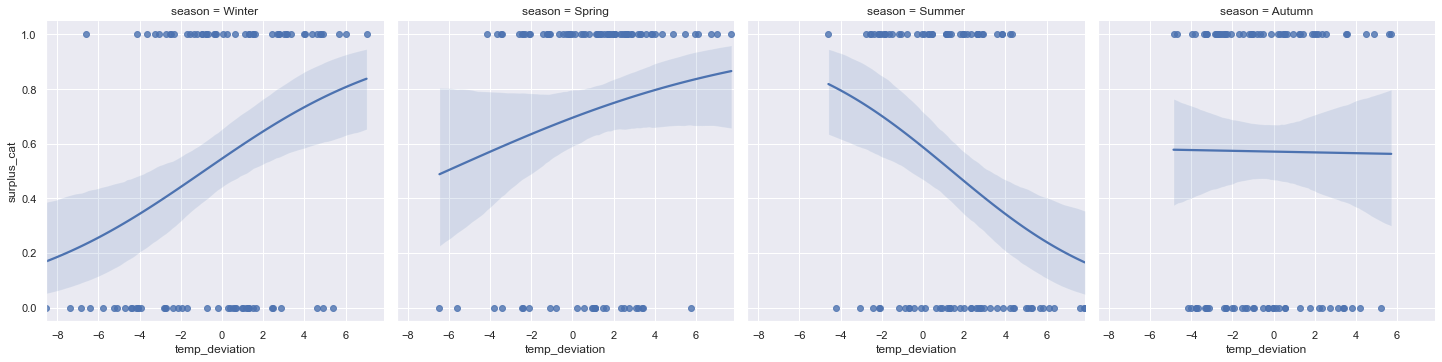

In [54]:
sns.lmplot(data=temperature_consumption, x='temp_deviation', y='surplus_cat', logistic=True, col='season')

Logistic regression is a well known method for classification problems, and is implemented in many libraries. Here we use the implementation from the library scikit-learn, which provides many metrics to assess the performance of the model.

The function below performs a logistic regression on the data pairs `(temp_deviation, surplus_cat)`, plots the receiver operating characteristic (ROC) curve, prints the model's accuracy and outputs the fitted model. 

In [48]:
def LR(X,y):
    clf = LogisticRegression(random_state=0, penalty='none').fit(X,y)

    fpr, tpr, _ = roc_curve(y, clf.predict_proba(X)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    
    print('Logistic regression accuracy: %f' % clf.score(X,y))
    
    return(clf)

Here are the results for the winter data:

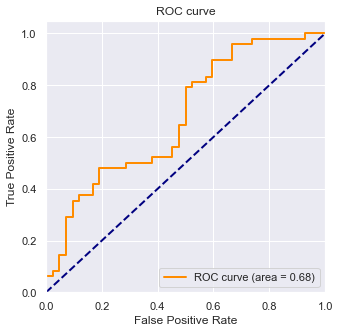

Logistic regression accuracy: 0.600000


LogisticRegression(penalty='none', random_state=0)

In [49]:
LR(X_winter, y_winter)

Here are the results for the summer data:

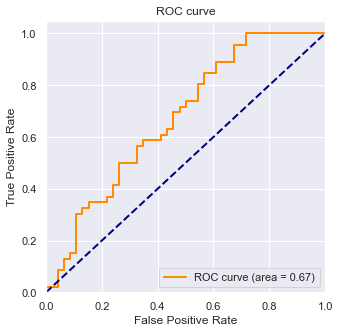

Logistic regression accuracy: 0.597826


LogisticRegression(penalty='none', random_state=0)

In [50]:
LR(X_summer, y_summer)

### Linear discriminant analysis (LDA)

LDA assumes a functional dependence of the probability of outcomes on the predictor variables similar to that of the logistic regression, but derives its parameters by making an additional assumption on the predictor variable data: its values should follow a gaussian distribution. Therefore, in cases where such assumption approximately holds, LDA can outperform logistic regression.

We will report the results of LDA in parallel with the reported results of logistic regression.

In [51]:
def LDA(X,y):
    clf = LinearDiscriminantAnalysis().fit(X,y)

    fpr, tpr, _ = roc_curve(y, clf.predict_proba(X)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    
    print('LDA accuracy: %f' % clf.score(X,y))
    
    return(clf)

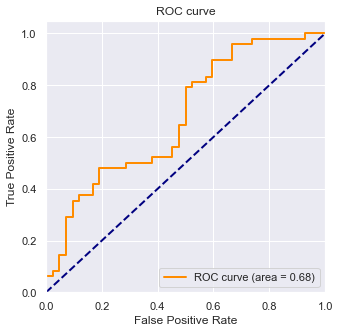

LDA accuracy: 0.600000


LinearDiscriminantAnalysis()

In [52]:
LDA(X_winter, y_winter)

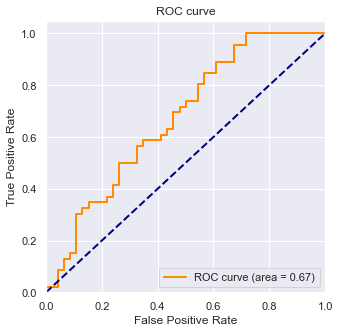

LDA accuracy: 0.597826


LinearDiscriminantAnalysis()

In [53]:
LDA(X_summer, y_summer)

Both models show the same performance because there is only one predictor variable and only 356 data points.

## Conclusions

- The joint distribution of the deviation of the daily mean temperature from the historical mean temperature and the daily mean energy surplus shows almost no statistical trend. However, when stratifying the data by meteorological season, some slight trends become apparent, whose nature depends on the season. As hipothesized, temperature deviations bear a (mild) positive correlation with energy surplus in winter, whereas the (mild) correlation is negative in summer.
- Two statistical models for predicting a surplus or deficit on the grid given a value of temperature deviation where applied. These models show some advantage over a random classification of surplus outcomes, which is however rather low in view of the limited data available.

## Outlook

The analysis could be extended and refined in at least two directions:
- Including historical energy consumption deviation data: this would allow us to use a finer resolution for the time series, which in turn would allow for (i) more sophisticated forecasts of temperature than historical mean temperature and (ii) more sophisticated models relating temperature and consumption deviations.
- Including further meteorological variables that account for wind and solar energy that enters the grid.